# Import Packages and Load Videos

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, Bidirectional, LayerNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers, optimizers
import albumentations as A
from albumentations import ReplayCompose
import numpy as np
import random, os, cv2, shutil
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os, zipfile, shutil, random, re, cv2, gdown


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_id = "1NAsGMLFtE6taowhMRz06EH5_us9H8v5C"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "videos.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NAsGMLFtE6taowhMRz06EH5_us9H8v5C
From (redirected): https://drive.google.com/uc?id=1NAsGMLFtE6taowhMRz06EH5_us9H8v5C&confirm=t&uuid=c5842aaa-9561-4278-8e82-5a1220ed694c
To: /content/videos.zip
100%|██████████| 1.78G/1.78G [00:22<00:00, 78.1MB/s]


'videos.zip'

In [5]:
extract_root = "/content/extracted videos"
with zipfile.ZipFile("videos.zip", 'r') as z:
    z.extractall(extract_root)

In [6]:
input_video_root = os.path.join(extract_root, "Shop DataSet")
categories = ["shop lifters", "non shop lifters"]  # keep spaces

In [7]:
for label in categories:
    folder = os.path.join(input_video_root, label)
    print(f"{label} :", len([f for f in os.listdir(folder) if f.endswith('.mp4')]), "videos")

shop lifters : 324 videos
non shop lifters : 531 videos


#Preprocessing



In [8]:
dup_folder = os.path.join(input_video_root, "non shop lifters")
if os.path.exists(dup_folder):
    all_files = os.listdir(dup_folder)
    file_set = set(all_files)
    for file_name in all_files:
        m = re.match(r"(shop_lifter.*)_\d+\.mp4$", file_name)
        if m:
            original_name = m.group(1) + ".mp4"
            if original_name in file_set:
                try:
                    os.remove(os.path.join(dup_folder, file_name))
                    print(f"Deleted duplicate: {file_name}")
                except Exception as e:
                    print("Delete error:", e)

Deleted duplicate: shop_lifter_n_109_1.mp4
Deleted duplicate: shop_lifter_n_26_1.mp4
Deleted duplicate: shop_lifter_n_90_1.mp4
Deleted duplicate: shop_lifter_n_53_1.mp4
Deleted duplicate: shop_lifter_n_60_1.mp4
Deleted duplicate: shop_lifter_n_138_1.mp4
Deleted duplicate: shop_lifter_n_106_1.mp4
Deleted duplicate: shop_lifter_n_159_1.mp4
Deleted duplicate: shop_lifter_n_194_1.mp4
Deleted duplicate: shop_lifter_n_72_1.mp4
Deleted duplicate: shop_lifter_n_30_1.mp4
Deleted duplicate: shop_lifter_n_29_1.mp4
Deleted duplicate: shop_lifter_n_39_1.mp4
Deleted duplicate: shop_lifter_n_160_1.mp4
Deleted duplicate: shop_lifter_n_57_1.mp4
Deleted duplicate: shop_lifter_n_210_1.mp4
Deleted duplicate: shop_lifter_n_99_1.mp4
Deleted duplicate: shop_lifter_n_119_1.mp4
Deleted duplicate: shop_lifter_n_97_1.mp4
Deleted duplicate: shop_lifter_n_173_1.mp4
Deleted duplicate: shop_lifter_n_12_1.mp4
Deleted duplicate: shop_lifter_n_54_1.mp4
Deleted duplicate: shop_lifter_n_172_1.mp4
Deleted duplicate: shop_

In [9]:
for label in categories:
    folder = os.path.join(input_video_root, label)
    print(f"{label} :", len([f for f in os.listdir(folder) if f.endswith('.mp4')]), "videos")

shop lifters : 324 videos
non shop lifters : 313 videos


In [10]:
frames_root = "/content/sampled_frames"
os.makedirs(frames_root, exist_ok=True)
target_framecount = 16

for label in categories:
    label_dir = os.path.join(input_video_root, label)
    out_label_dir = os.path.join(frames_root, label)
    os.makedirs(out_label_dir, exist_ok=True)

    for video_name in os.listdir(label_dir):
        if not video_name.endswith(".mp4"):
            continue
        video_path = os.path.join(label_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Failed to open:", video_path)
            continue

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames < target_framecount:
            print(f"Skipping {video_name}, only {total_frames} frames")
            cap.release()
            continue

        indices = np.linspace(0, total_frames - 1, target_framecount, dtype=int)
        frame_id, selected = 0, 0
        success = True

        while selected < target_framecount:
            ret, frame = cap.read()
            if not ret:
                success = False
                break
            if frame_id in indices:
                fname = f"{os.path.splitext(video_name)[0]}_frame_{selected:03d}.jpg"
                cv2.imwrite(os.path.join(out_label_dir, fname), frame)
                selected += 1
            frame_id += 1

        cap.release()
        if not success:
            # Remove partial frames if reading failed mid-way
            prefix = os.path.splitext(video_name)[0] + "_frame_"
            for f in os.listdir(out_label_dir):
                if f.startswith(prefix):
                    os.remove(os.path.join(out_label_dir, f))

print(" Frames extracted.")

 Frames extracted.


In [11]:
dataset_root = "/content/dataset"
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
for split in ["train", "val", "test"]:
    for c in categories:
        os.makedirs(os.path.join(dataset_root, split, c), exist_ok=True)

for category in categories:
    category_dir = os.path.join(frames_root, category)
    videos_dict = defaultdict(list)
    for img in os.listdir(category_dir):
        if "_frame_" not in img:
            continue
        base = img.split("_frame_")[0]
        videos_dict[base].append(img)

    # only keep videos with exactly 16 frames saved
    valid_videos = [v for v in videos_dict if len(videos_dict[v]) == target_framecount]
    random.shuffle(valid_videos)

    total = len(valid_videos)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    splits = {
        "train": valid_videos[:train_end],
        "val":   valid_videos[train_end:val_end],
        "test":  valid_videos[val_end:]
    }

    for split, vids in splits.items():
        for v in vids:
            dst_folder = os.path.join(dataset_root, split, category, v)
            os.makedirs(dst_folder, exist_ok=True)
            for img in videos_dict[v]:
                shutil.copy(os.path.join(category_dir, img), os.path.join(dst_folder, img))

print(" Dataset split ready.")

 Dataset split ready.


In [12]:
# ======== Augmentation =========

transform = A.ReplayCompose([
    A.HorizontalFlip(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
    A.RandomBrightnessContrast(p=0.4),
])

# ======== Frame Generator =========

class FrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, labels_map, batch_size=8, frame_count=16,
                 img_size=(224,224), shuffle=True, augment=False):
        self.directory = directory
        self.labels_map = labels_map
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.samples = self._load_samples()
        self.on_epoch_end()

    def _load_samples(self):
        samples = []
        for label, idx in self.labels_map.items():
            folder = os.path.join(self.directory, label)
            if not os.path.exists(folder): continue
            for video_folder in os.listdir(folder):
                path = os.path.join(folder, video_folder)
                if os.path.isdir(path):
                    samples.append((path, idx))
        return samples

    def __len__(self):
        return len(self.samples) // self.batch_size

    def __getitem__(self, index):
        batch = self.samples[index*self.batch_size:(index+1)*self.batch_size]
        X, y = [], []
        for path, label in batch:
            frames = self._load_frames(path)
            X.append(frames)
            y.append(label)
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def _load_frames(self, video_folder):
        img_files = sorted([f for f in os.listdir(video_folder) if f.endswith('.jpg')])
        if len(img_files) > self.frame_count:
            img_files = np.random.choice(img_files, self.frame_count, replace=False)
        img_files = sorted(img_files)

        frames = []
        replay = None
        for i, img_file in enumerate(img_files):
            img_path = os.path.join(video_folder, img_file)
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.augment:
                if i == 0:
                    out = transform(image=img)
                    img = out['image']
                    replay = out['replay']
                else:
                    img = ReplayCompose.replay(replay, image=img)['image']

            img = img.astype(np.float32) / 127.5 - 1.0
            img = np.clip(img, -1.0, 1.0)
            frames.append(img)

        while len(frames) < self.frame_count:
            frames.append(frames[-1].copy())

        return np.stack(frames, axis=0)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
# ======== Data Generators =========

labels_map = {"shop lifters": 1, "non shop lifters": 0}  # 1 = positive class
train_gen = FrameGenerator(os.path.join(dataset_root, "train"), labels_map, batch_size=8, augment=True)
val_gen   = FrameGenerator(os.path.join(dataset_root, "val"), labels_map, batch_size=8, augment=False)
test_gen  = FrameGenerator(os.path.join(dataset_root, "test"), labels_map, batch_size=8, augment=False)

Batch shape: (8, 16, 224, 224, 3)
Labels shape: (8,)
Example labels: [1. 1. 1. 1. 1.]


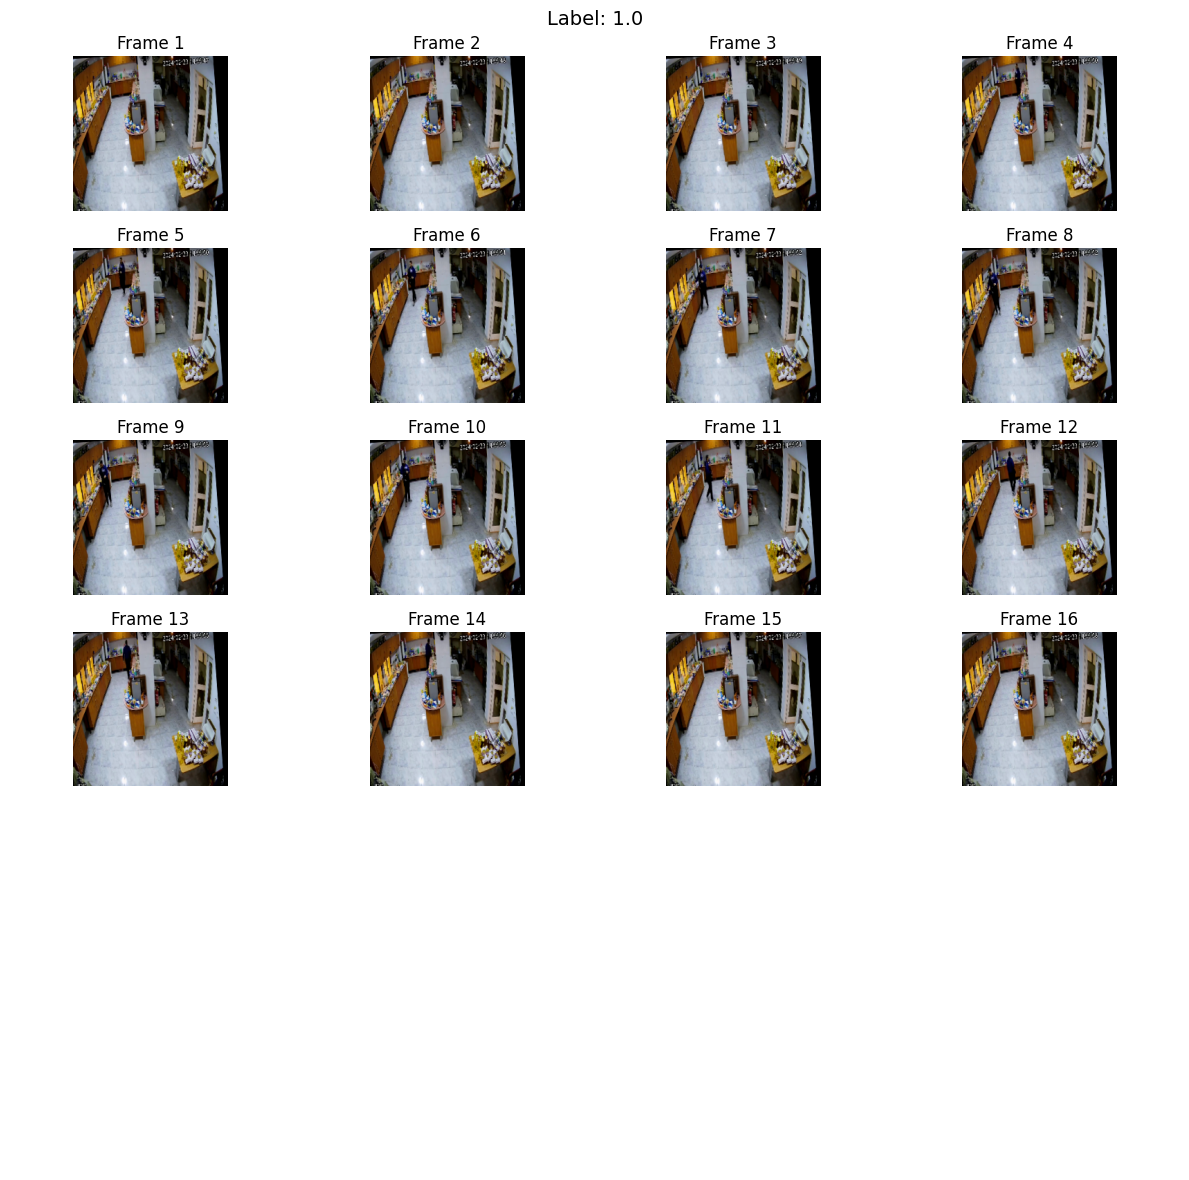

In [31]:
# get one batch from the generator
X_batch, y_batch = train_gen[11]

print("Batch shape:", X_batch.shape)
print("Labels shape:", y_batch.shape)
print("Example labels:", y_batch[:5])

video_idx = 0
frames = X_batch[video_idx]
label = y_batch[video_idx]

def denormalize(img):
    img= ((img + 1) * 127.5).astype(np.uint8)
    #img = np.clip(img, 0, 255)
    return img

# plot that video frames
fig, axes = plt.subplots(6, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(frames):
        ax.imshow(denormalize(frames[i]))
        ax.set_title(f"Frame {i+1}")
    ax.axis("off")

plt.suptitle(f"Label: {label}", fontsize=14)
plt.tight_layout()
plt.show()


#Modeling Stage 1: Freeze CNN

> Add blockquote



In [15]:
def build_model(frame_count=16):
    base_cnn = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    model = Sequential([
        TimeDistributed(base_cnn, input_shape=(frame_count,224,224,3)),
        TimeDistributed(GlobalAveragePooling2D()),
        Bidirectional(LSTM(128, return_sequences=False)),
        LayerNormalization(),
        Dropout(0.5),
        Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        Dense(1, activation="sigmoid")  # Sigmoid for binary classification
    ])
    return model

In [16]:
model = build_model(frame_count=16)
for layer in model.layers[0].layer.layers:
    layer.trainable = False

loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

initial_lr = 1e-3
epochs_stage1 = 20
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=epochs_stage1 * len(train_gen),
    alpha=1e-5
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint("stage1_best_sigmoid.keras", save_best_only=True, monitor="val_loss")
]

history1 = model.fit(train_gen, validation_data=val_gen, epochs=epochs_stage1, callbacks=callbacks)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5044 - auc: 0.5339 - loss: 0.8608 - val_accuracy: 0.4896 - val_auc: 0.9214 - val_loss: 0.6954
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4868 - auc: 0.4782 - loss: 0.8007 - val_accuracy: 0.4896 - val_auc: 0.9390 - val_loss: 0.6668
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5536 - auc: 0.5545 - loss: 0.7347 - val_accuracy: 0.7708 - val_auc: 0.9344 - val_loss: 0.6343
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5741 - auc: 0.5893 - loss: 0.7056 - val_accuracy: 0.5104 - val_auc: 0.9336 - val_loss: 0.6492
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5735 - auc: 0.6431 - loss: 0.6925 - val_accuracy: 0.7708 - val_auc: 0.9362 - val_loss: 0.5891
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6574 - auc: 0.7143 - loss: 0.6470 - val_accuracy: 0.7500 - val_auc: 0.9390 - val_loss: 0.5828
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step -

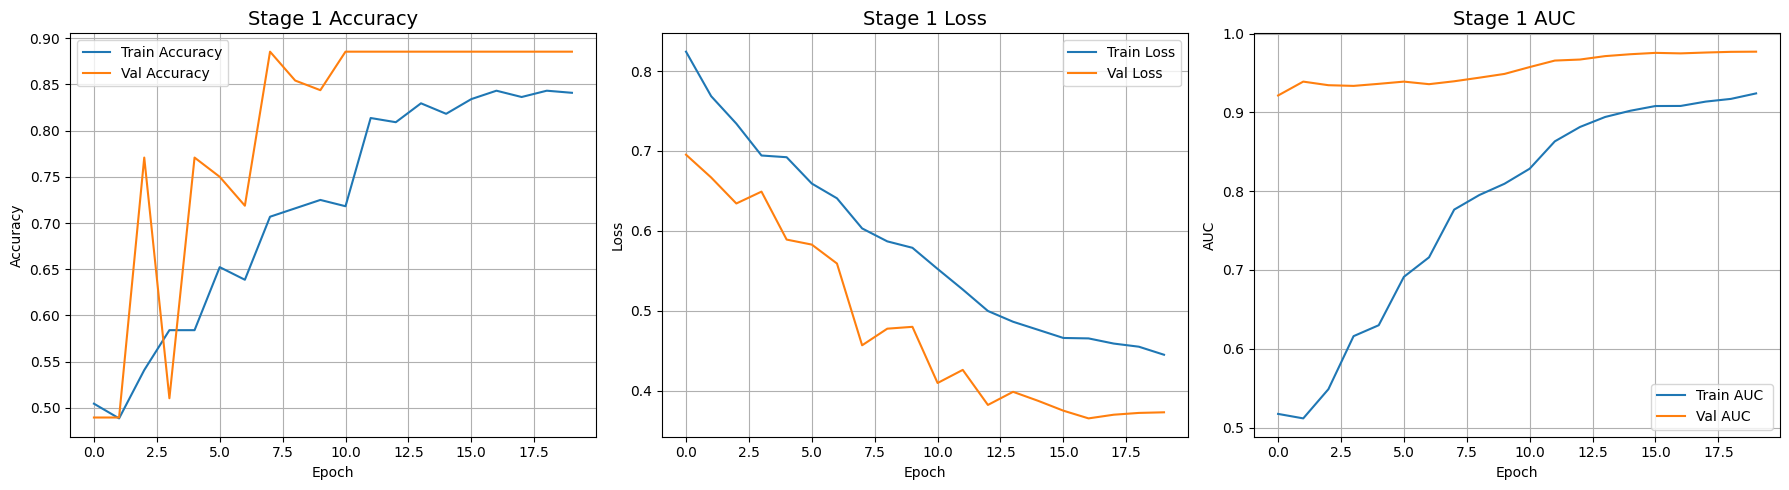

In [17]:
history = history1

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Accuracy subplot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Stage 1 Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss subplot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Stage 1 Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# AUC subplot
axes[2].plot(history.history['auc'], label='Train AUC ')
axes[2].plot(history.history['val_auc'],  label=r'Val AUC')
axes[2].set_title('Stage 1 AUC ', fontsize=14)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [18]:
from google.colab import files

model.save("Shop_Lifter_Freezed_Model.h5")
files.download("Shop_Lifter_Freezed_Model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Modeling Stage 2: Fine-tuning

In [19]:
# ======== Stage 2: Fine-tune last 40 CNN layers =========
base_cnn = model.layers[0].layer
for i, layer in enumerate(base_cnn.layers):
    layer.trainable = (i >= len(base_cnn.layers) - 40)

initial_lr_ft = 2e-4
epochs_stage2 = 10
lr_schedule_ft = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr_ft,
    decay_steps=epochs_stage2 * len(train_gen),
    alpha=1e-6
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule_ft),
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)

callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint("stage2_best_sigmoid.keras", save_best_only=True, monitor="val_loss")
]

history2 = model.fit(train_gen, validation_data=val_gen, epochs=epochs_stage2, callbacks=callbacks_ft)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.7118 - auc: 0.7673 - loss: 0.7139 - val_accuracy: 0.9062 - val_auc: 0.9891 - val_loss: 0.4684
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8329 - auc: 0.9122 - loss: 0.4728 - val_accuracy: 0.9792 - val_auc: 0.9987 - val_loss: 0.2751
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8621 - auc: 0.9472 - loss: 0.4122 - val_accuracy: 0.9896 - val_auc: 1.0000 - val_loss: 0.2673
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8842 - auc: 0.9444 - loss: 0.4089 - val_accuracy: 0.9688 - val_auc: 0.9989 - val_loss: 0.2730
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8629 - auc: 0.9271 - loss: 0.4512 - val_accuracy: 0.9896 - val_auc: 1.0000 - val_loss: 0.2290
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9006 - auc: 0.9762 - loss: 0.3446 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.2173
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step -

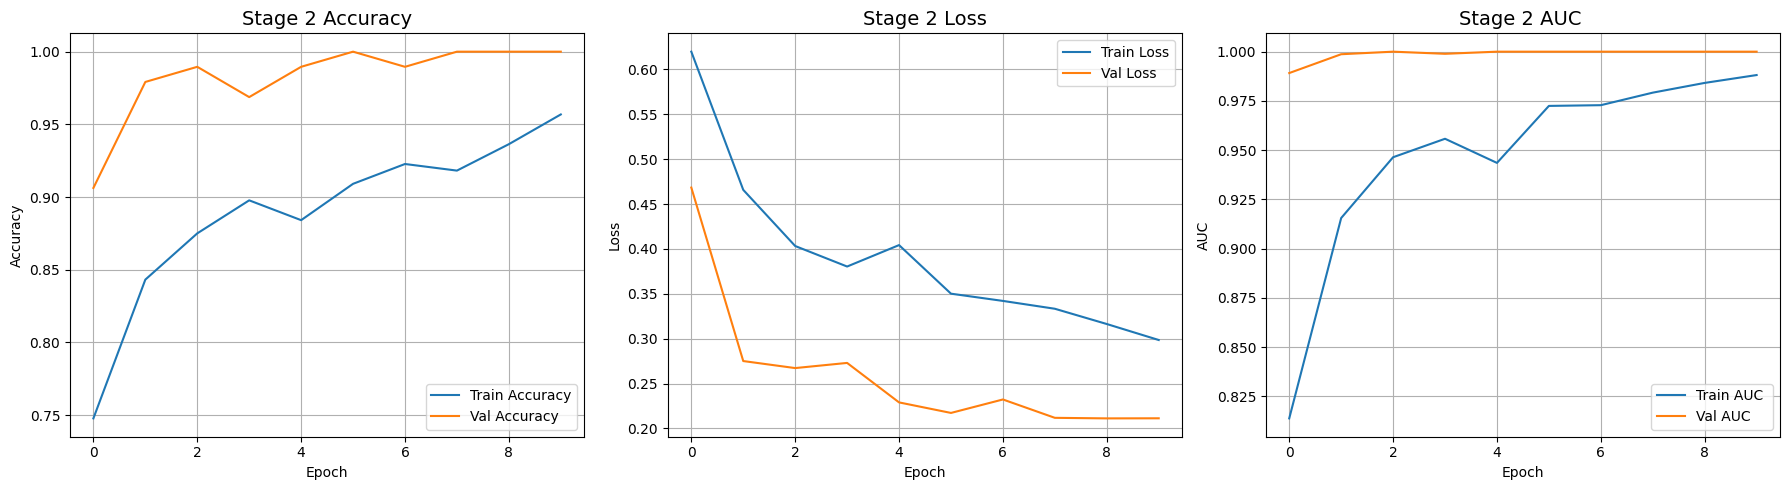

In [26]:
history = history2

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Accuracy subplot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Stage 2 Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss subplot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Stage 2 Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# AUC subplot
axes[2].plot(history.history['auc'], label='Train AUC ')
axes[2].plot(history.history['val_auc'],  label=r'Val AUC')
axes[2].set_title('Stage 2 AUC ', fontsize=14)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [20]:
from google.colab import files
import shutil

model.save("Shop_Lifter_Tuned_Model.h5")
model.export("Shop_Lifter_Tuned_Model_tf")  # هيعمل فولدر كامل
files.download("Shop_Lifter_Tuned_Model.h5")
shutil.make_archive("Shop_Lifter_Tuned_Model_tf", 'zip', "Shop_Lifter_Tuned_Model_tf")
files.download("Shop_Lifter_Tuned_Model_tf.zip")


Saved artifact at 'Shop_Lifter_Tuned_Model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137374872985936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872987088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872987472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872986704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872985744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872987280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872987664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872988432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872988048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137374872985168: TensorSpec(shape=(), dtype=tf.resource, name=None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Evaluation

In [22]:
print("Evaluating on test set…")
test_loss, test_acc, test_auc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating on test set…


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 735ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2096
Test Loss: 0.2095
Test Accuracy: 1.0000
Test AUC: 1.0000


In [27]:
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    preds = model.predict(X_batch)
    preds_label = (preds > 0.5).astype(int).flatten()
    y_pred.extend(preds_label)
    y_true.extend(y_batch.astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

In [28]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Shop Lifter", "Shop Lifter"]))


Classification Report:
                 precision    recall  f1-score   support

Non-Shop Lifter       1.00      1.00      1.00        47
    Shop Lifter       1.00      1.00      1.00        49

       accuracy                           1.00        96
      macro avg       1.00      1.00      1.00        96
   weighted avg       1.00      1.00      1.00        96



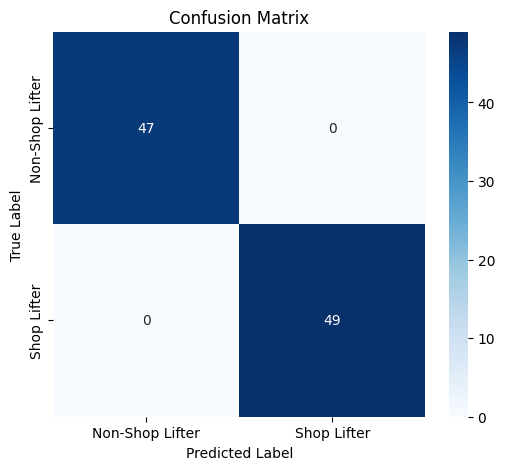

In [29]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Shop Lifter", "Shop Lifter"], yticklabels=["Non-Shop Lifter", "Shop Lifter"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()